<a href="https://colab.research.google.com/github/Beatrixwmh/phase-3-project/blob/main/phase_3_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Final Project Submission**<br>
Student name: Beatrx Wong <br>
Studnet pace: flex<br>
Scheduled project review date/time: 6/12/2023, 2:00 pm <br>
Instructor name: Morgan Jones <br>
Blog post URL

### Introduction
In this notebook, I will analyse data about past customers in SyriaTel and use it to create binary classification models that predict whether a customer would soon stop doing business with the company.

In [1]:
#import necessary libraries
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, precision_score, recall_score, confusion_matrix

### **Data Preparation**<br>
****Inspecting and tidying up data for analysis****<br>
In this section, I will look at the data and do the necessary transformations to prepare it for modelling.

In [2]:

df= pd.read_csv('data.csv')

In [3]:
#Check to see if the data has been imported properly
df.head()

state  account length  area code phone number international plan  \
0    KS             128        415     382-4657                 no   
1    OH             107        415     371-7191                 no   
2    NJ             137        415     358-1921                 no   
3    OH              84        408     375-9999                yes   
4    OK              75        415     330-6626                yes   

  voice mail plan  number vmail messages  total day minutes  total day calls  \
0             yes                     25              265.1              110   
1             yes                     26              161.6              123   
2              no                      0              243.4              114   
3              no                      0              299.4               71   
4              no                      0              166.7              113   

   total day charge  ...  total eve calls  total eve charge  \
0             45.07  ...               99             16.78   
1             27.47  ...              103             16.62   
2             41.38  ...              110             10.30   
3             50.90  ...               88              5.26   
4             28.34  ...              122             12.61   

   total night minutes  total night calls  total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   total intl minutes  total intl calls  total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   customer service calls  churn  
0                       1  False  
1                       1  False  
2                       0  False  
3                       2  False  
4                       3  False  

[5 rows x 21 columns]

In [4]:
#Inpect columns and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [12]:
#check class imbalance
df['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

****Dropping unhelpful information**** <br>
Since there are no null values, filling in missing information is not needed. Next, I will drop informtation that is not useful for prediction to reduce the amount of noise in our model.<br>
The most immdediately obvious unneeded data is phone number, since it is unqiue to each customer and does not correlate to customer behavior.

In [4]:
#drop phone number column
df.drop(['phone number'], axis=1, inplace= True)
df.head()

state  account length  area code international plan voice mail plan  \
0    KS             128        415                 no             yes   
1    OH             107        415                 no             yes   
2    NJ             137        415                 no              no   
3    OH              84        408                yes              no   
4    OK              75        415                yes              no   

   number vmail messages  total day minutes  total day calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   total day charge  total eve minutes  total eve calls  total eve charge  \
0             45.07              197.4               99             16.78   
1             27.47              195.5              103             16.62   
2             41.38              121.2              110             10.30   
3             50.90               61.9               88              5.26   
4             28.34              148.3              122             12.61   

   total night minutes  total night calls  total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   total intl minutes  total intl calls  total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   customer service calls  churn  
0                       1  False  
1                       1  False  
2                       0  False  
3                       2  False  
4                       3  False

To further look into the correlation between other variables and our target, I will first transform the object values into binary data for easier analysis.

In [5]:

#get list of column names with object values
object_cols= [x for x in df.columns if df[x].dtype== object]
#create binary values for those columns
dummies= pd.get_dummies(df[object_cols], drop_first=True)
#combine transformed data with the rest of the data
data= pd.concat([df.drop(object_cols, axis=1), dummies], axis=1)
data.head()

account length  area code  number vmail messages  total day minutes  \
0             128        415                     25              265.1   
1             107        415                     26              161.6   
2             137        415                      0              243.4   
3              84        408                      0              299.4   
4              75        415                      0              166.7   

   total day calls  total day charge  total eve minutes  total eve calls  \
0              110             45.07              197.4               99   
1              123             27.47              195.5              103   
2              114             41.38              121.2              110   
3               71             50.90               61.9               88   
4              113             28.34              148.3              122   

   total eve charge  total night minutes  ...  state_TX  state_UT  state_VA  \
0             16.78                244.7  ...         0         0         0   
1             16.62                254.4  ...         0         0         0   
2             10.30                162.6  ...         0         0         0   
3              5.26                196.9  ...         0         0         0   
4             12.61                186.9  ...         0         0         0   

   state_VT  state_WA  state_WI  state_WV  state_WY  international plan_yes  \
0         0         0         0         0         0                       0   
1         0         0         0         0         0                       0   
2         0         0         0         0         0                       0   
3         0         0         0         0         0                       1   
4         0         0         0         0         0                       1   

   voice mail plan_yes  
0                    1  
1                    1  
2                    0  
3                    0  
4                    0  

[5 rows x 69 columns]

Next, I can look at the correlation between each column and the target and drop the columns with a correlation score of less than 0.05. This is a very low requirement, so I can be quite sure the data I dropped would not have much positive impact on predictions.

In [6]:
#select columns that show correlation with target (magnitude>=0.05)
useful_columns= data.corr()[np.abs(data.corr()['churn']) >=0.05]['churn'].index.drop(['churn'])
useful_columns

Index(['number vmail messages', 'total day minutes', 'total day charge',
       'total eve minutes', 'total eve charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls',
       'international plan_yes', 'voice mail plan_yes'],
      dtype='object')

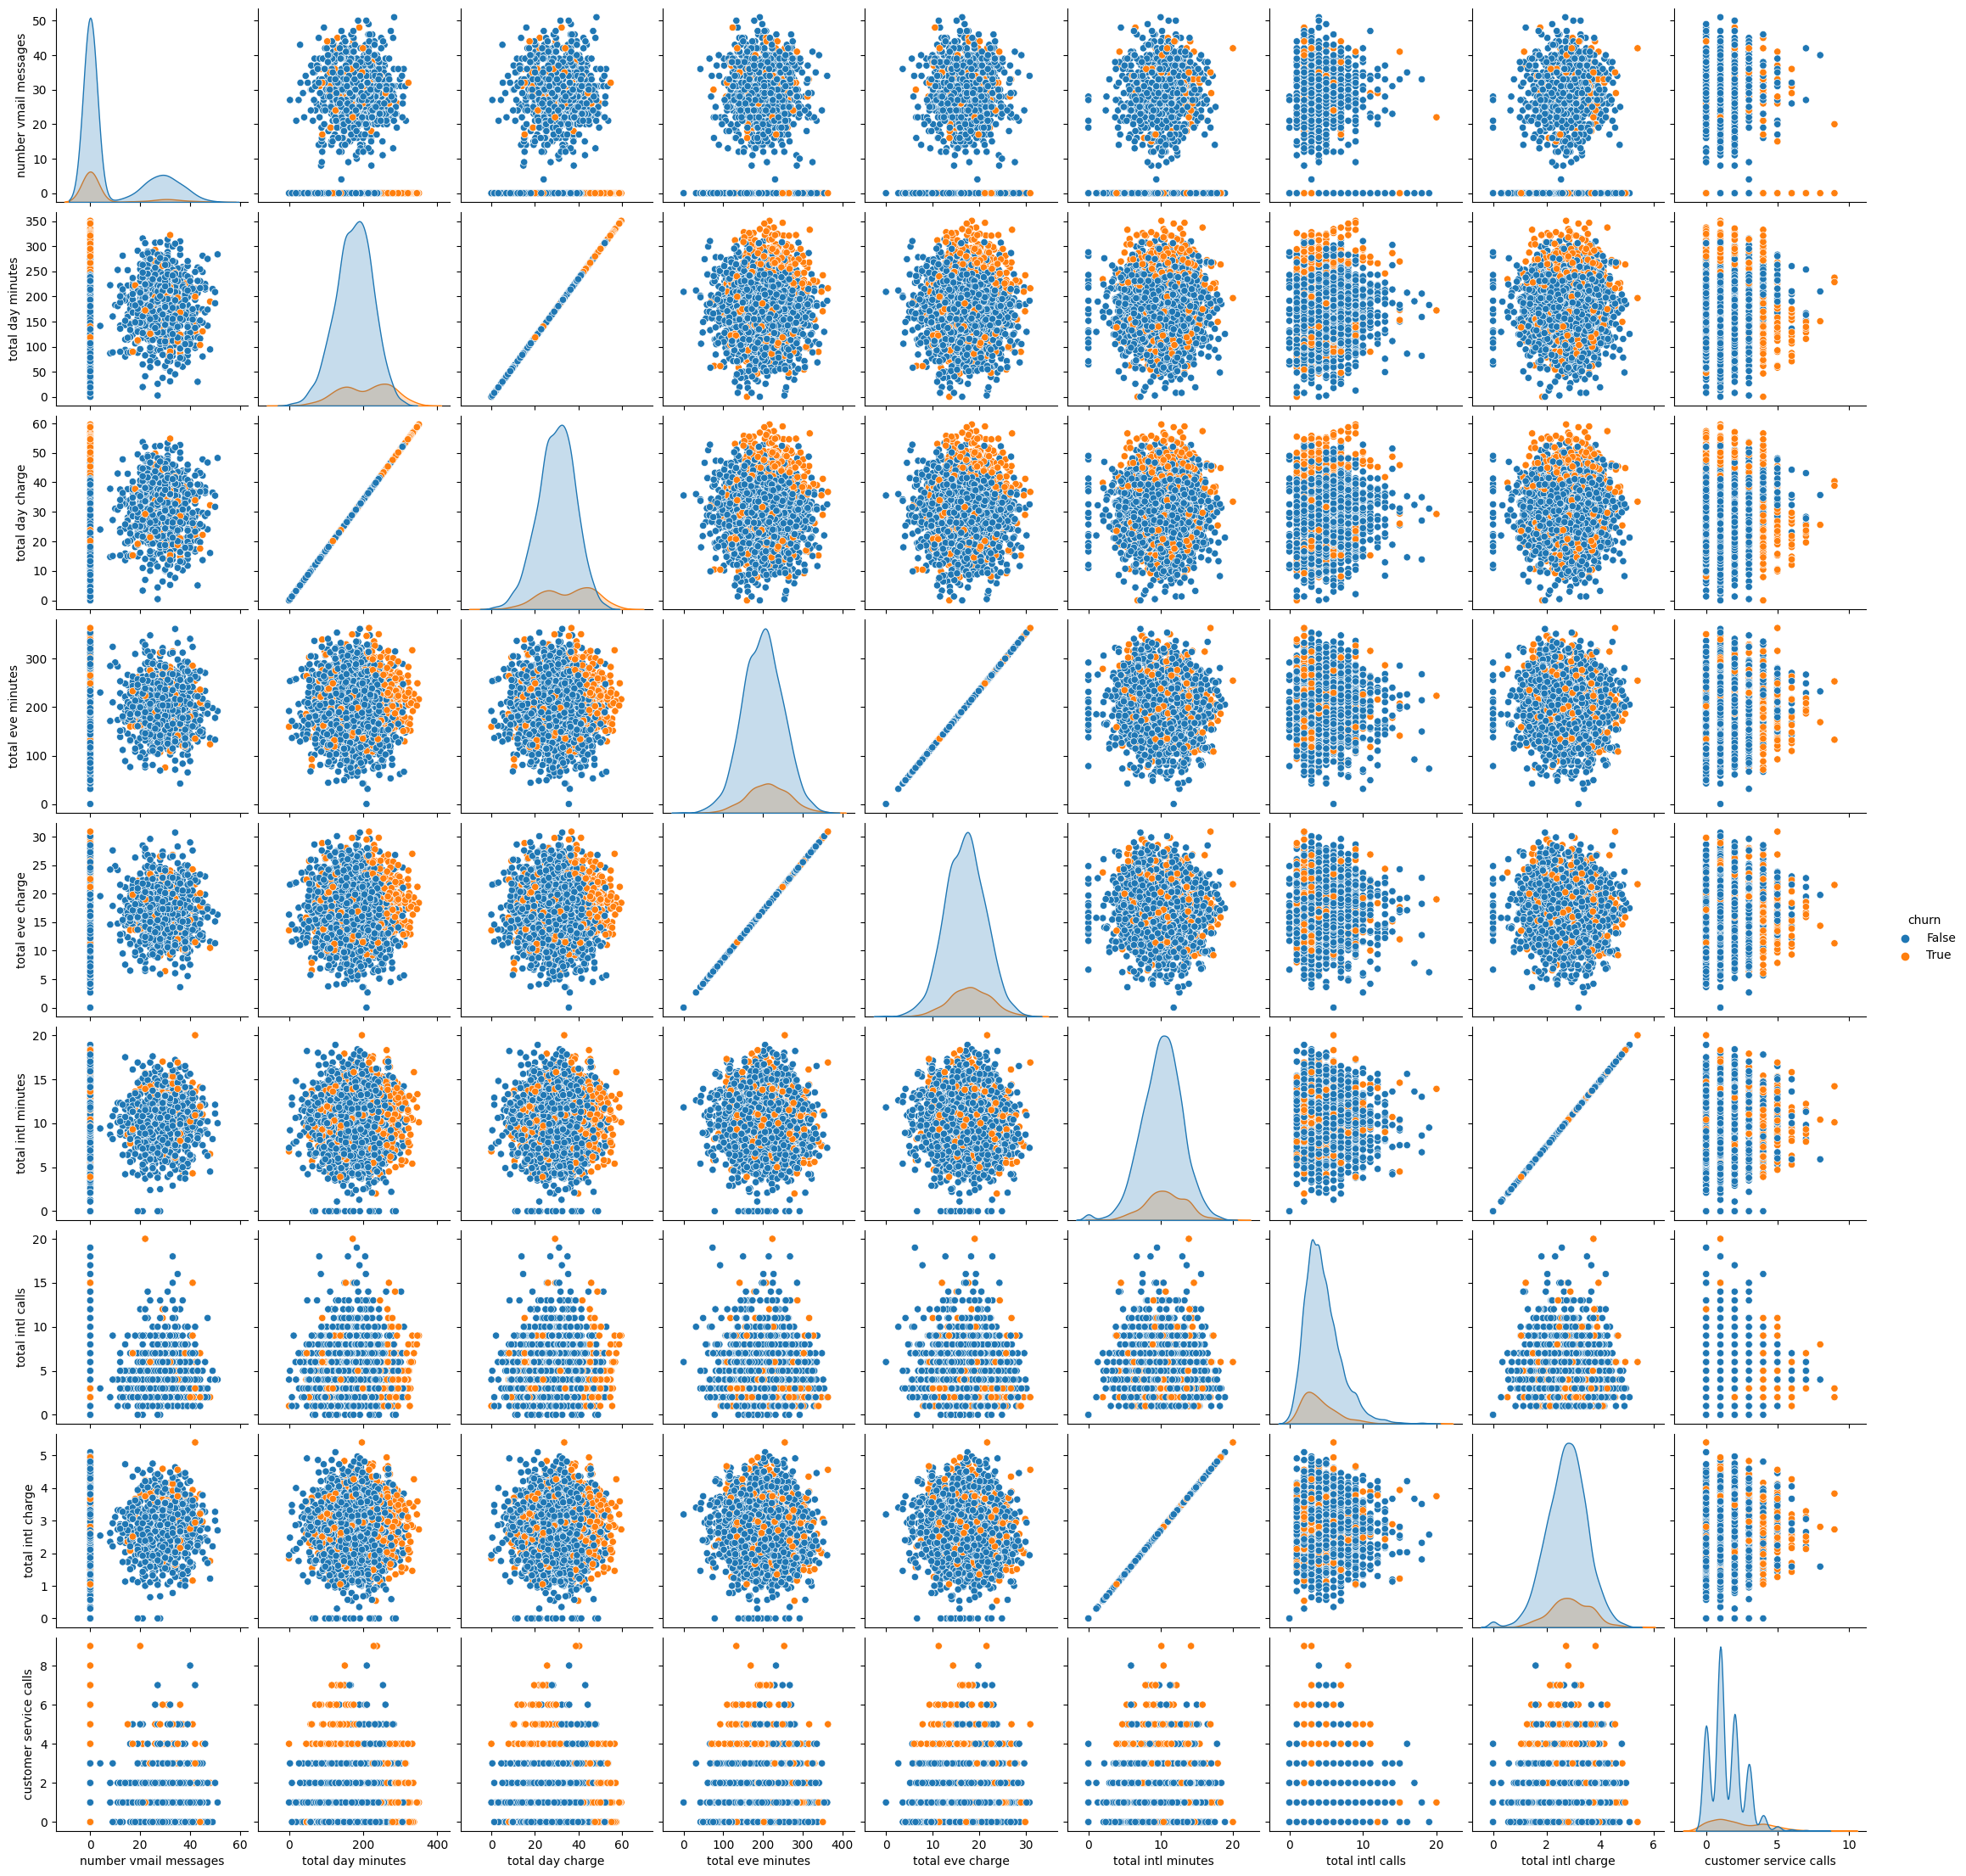

In [ ]:
#knowing the useful columns, I will first look at the data distribution and correlations
import seaborn as sns
snsdata= pd.concat([df[useful_columns[:-2]], df[['international plan','churn']]], axis=1)
sns.pairplot(snsdata, hue= 'churn')

The data seems very spread out with no discernable pattern at first glance, besides a very direct correlation between total day minutes and total day charge, and total intl minutes and total intl charge, however, multicollinearity will not affect decsion trees' predictive power. <br>
Next, I will seperate the target from the rest of the data to prepare it for processing.

In [7]:
#seperate variables from target
X= data.drop(['churn'], axis=1)
#drop unuseful columns from the variables
X= X[useful_columns]
#isolate target column
y= df['churn']

In [9]:
#train test split to prepare for modelling
X_train, X_test, y_train,y_test= train_test_split(X,y, test_size= 0.25, random_state=14)

### **Modelling and Evaluation**<br>
Now that the data is ready to be used for modelling, I will experiment with different types of modelling, compare the results against one another in an attempt to find the best one. <br>
For the baseline model, I will use decision tree classifier with default parameters.<br>
Since the task is to identify churning customers correctly, I will be looking to reduce false negatives while also balancing the number of flase positives, becasue the company would lose money both for being overly trusting and overly suspicious of its customers. Therefore for the evaluation of models, I will be looking at the macro recall score in cross validation since it puts equal weight on false negatives and false positives, and I will be looking at the true recall score in the classification reports since it gives me information about the false negative rate.

In [ ]:
#Baseline model
dt_clf= DecisionTreeClassifier()
print('mean train recall score for baseline:', cross_val_score(dt_clf, X_train,y_train,scoring='recall_macro', cv=5).mean())
dt_clf.fit(X_train,y_train)
print('test classification report for baseline model: \n')
print(classification_report(y_test, dt_clf.predict(X_test)))

mean train recall score for baseline: 0.8166193161043103
test classification report for baseline model: 

              precision    recall  f1-score   support

       False       0.95      0.95      0.95       710
        True       0.73      0.71      0.72       124

    accuracy                           0.92       834
   macro avg       0.84      0.83      0.83       834
weighted avg       0.92      0.92      0.92       834



In [ ]:
# visualizing confusion matrices for train and test data
cm_train= confusion_matrix(y_train,dt_clf.predict(X_train))
cm_test= confusion_matrix(y_test, dt_clf.predict(X_test))

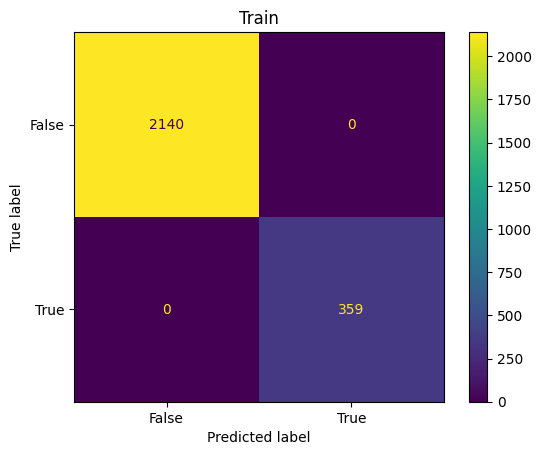

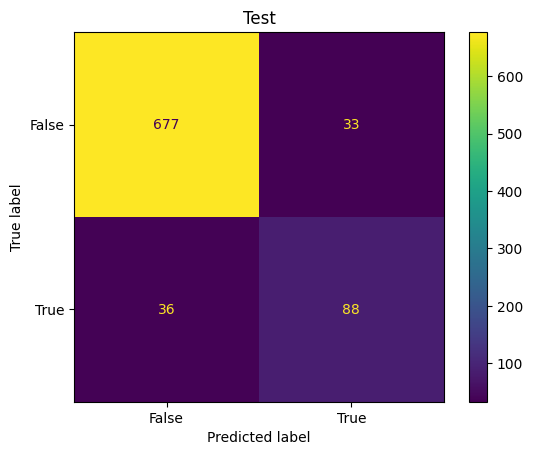

In [ ]:
disp= ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels= dt_clf.classes_)
disp.plot()
disp.ax_.set_title('Train')
disp2= ConfusionMatrixDisplay(confusion_matrix= cm_test, display_labels= dt_clf.classes_)
disp2.plot()
disp2.ax_.set_title('Test')
plt.show()

Since this model performs very well with the training data but does significantly worse with the testing data, it is obvious that the decision tree model is overfitting. To reduce overfitting, I will try radnom forest next.

In [10]:
#random forest
rf_clf= RandomForestClassifier(random_state= 14)
print('mean training recall for rf:', cross_val_score(rf_clf,X_train, y_train, cv=5, scoring= 'recall_macro').mean())
rf_clf.fit(X_train,y_train)
print('test calssification report for rf: \n',classification_report(y_test, rf_clf.predict(X_test)))

mean training recall for rf: 0.8735647428782833
test calssification report for rf: 
               precision    recall  f1-score   support

       False       0.96      0.98      0.97       726
        True       0.84      0.73      0.78       108

    accuracy                           0.95       834
   macro avg       0.90      0.86      0.88       834
weighted avg       0.95      0.95      0.95       834



### **Tuning the model** <br>
Random forest has better precision, but the recall score is hardly improved and there are still a lot of false negatives, which is what we want to reduce. This might be due to the class imbalance causing an oversampling of negative cases. <br>
To try to fix this problem, I will use SMOTE to generate more data points for True cases and train a random forest model using the new, balanced data.


In [36]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as  imbpipeline
#create pipeline with SMOTE and random forest
pipeline_sm= imbpipeline([('sm', SMOTE(random_state=14)),
                    ('rf', RandomForestClassifier(random_state=14))])
#find mean recall score
cross_val_score(pipeline_sm, X_train,y_train, scoring= 'recall_macro').mean()

0.8576337402885681

In [56]:
#classifcation repot 
pipeline_sm.fit(X_train,y_train)
print(classification_report(y_test, pipeline_sm.predict(X_test)))

              precision    recall  f1-score   support

       False       0.96      0.92      0.94       726
        True       0.58      0.73      0.64       108

    accuracy                           0.90       834
   macro avg       0.77      0.83      0.79       834
weighted avg       0.91      0.90      0.90       834



In [58]:
#look at confusion matrices
print('train_cm : \n', confusion_matrix(y_train, pipeline_sm.predict(X_train)))
print('test cm: \n', confusion_matrix(y_test, pipeline_sm.predict(X_test)))

train_cm : 
 [[2124    0]
 [   0  375]]
test cm: 
 [[668  58]
 [ 29  79]]


The random forest model after SMOTE performs significantly worse than the untuned version before resampling. It has hardly improved in recall score, but is much worse at precision. The former could be due to a high variance in true cases such that the data generated by SMOTE is not representative of unseen data, while the latter could be due to the undersampling of false cases causing the model to be underfitted.  <br>
Looking at the confusion matrices, it also seems like the model is overfitting to train data. Next, I will try to reduce overfitting and increase precision of this model by tuning hyperparameters using gridsearchCV.

In [51]:
#possible params that reduce overfitting
rf_param_grid = {
    "rf__n_estimators": [100,150, 200],
    "rf__max_depth": [2, 6, 10],
    "rf__min_samples_split": [5, 10,15],
}
#grid search for best params
rf_grid_search = GridSearchCV(pipeline_sm, rf_param_grid, cv=3, scoring= 'precision')
rf_grid_search.fit(X_train, y_train)

print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Optimal Parameters: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 150}


In [53]:
print(f'Best precision score: {rf_grid_search.best_score_ :.2%}')

Best precision score: 70.75%


In [57]:
#classification metrics for tuned model
rf_sm_tuned= RandomForestClassifier(n_estimators= 150, min_samples_split=5, max_depth= 10, random_state=14)
pipeline2= imbpipeline([('sm', SMOTE(random_state=14)),
                        ('rf_tuned', rf_sm_tuned)])
pipeline2.fit(X_train,y_train)
print(classification_report(y_test,pipeline2.predict(X_test) ))

              precision    recall  f1-score   support

       False       0.96      0.93      0.95       726
        True       0.62      0.74      0.67       108

    accuracy                           0.91       834
   macro avg       0.79      0.84      0.81       834
weighted avg       0.92      0.91      0.91       834



While this tuned model has slightly better metrics than the previous one, the overall metrics are still significantly worse than my first random forest model with default paramters and untrasnformed data, therefore, I would say the random forest with default parameters and trained with the orginal data is the best model.

### **The final model**<br>
I will now look further into my random forest model to evaluate its performance and utility.

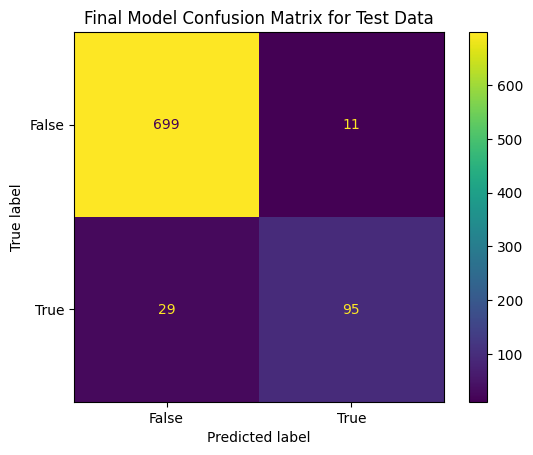

In [ ]:
#confusion matrix on test set
final_model= rf_clf
cm_final_test= confusion_matrix(y_test, final_model.predict(X_test))
disp_f= ConfusionMatrixDisplay(confusion_matrix= cm_final_test, display_labels= rf_clf.classes_)
disp_f.plot()
disp_f.ax_.set_title('Final Model Confusion Matrix for Test Data')
plt.show()

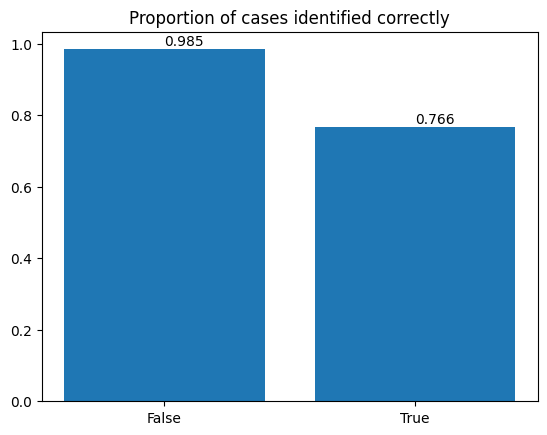

In [ ]:
#visualise recall for each class
neg_re= cm_final_test[0][0]/sum(cm_final_test[0])
pos_re= cm_final_test[1][1]/sum(cm_final_test[1])
plt.bar(['False', 'True'],[neg_re, pos_re])
plt.text('False', neg_re+0.01, str(round(neg_re,3)))
plt.text('True', pos_re+0.01, str(round(pos_re,3)))
plt.title('Proportion of clases identified correctly')
plt.show()

In [ ]:
print('This model is able to identify a churning client around {} % of the time.'.format(round(pos_re*100)))
print('This model is able to identify a staying client around {} % of the time.'.format(round(neg_re*100)))

This model is able to identify a churning client around 77 % of the time.
This model is able to identify a staying client around 98 % of the time.


While this model does very well with identifying loyal customers, it is not nearly as accurate when it comes to identifying churning customers, meaning relying on this model would cause one to be overly trusting of customers. <br>
This issue could be attributed to the class imbalance of the dataset, with there being disproportionately less churning data, so there is not enough information for the model to learn how to identify true cases accurately.
### Next Steps
Moving forward, I would reccommend the telecom company to gather more information about customers who churn so the resulting prediction model would be more accurate. Moreover, having a larger dataset would also be helpful for training a better model.